In [1]:

import pandas as pd 
import torch
from torch import nn 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np
from tqdm import tqdm
import scipy.stats as stats

torch.__version__

'2.0.0+cu118'

### Load embeddings here into tensors (each with 30 features (until later we combine with Edward's 30 to make 60))

In [55]:
#load embeddings here for train and test sets
import pandas as pd
import sys
import os
import ast
import pickle
#from google.colab import drive 
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/ReLSO'
#%cd '/content/gdrive/My Drive/ReLSO'
#sys.path.append(root_path)

# def read_file()

train_embedding_df = pd.read_csv("/content/train_embeddings.csv").sort_values('Sequences')
train_immuno_df = pd.read_csv('/content/continuous_immuno_labels_train.txt', delimiter='\t', skiprows=1, header=None).sort_values(0)

# train_immuno_df = pd.read_csv('continuous_train.txt', delimiter='\t', skiprows=1, header=None)[1].tolist()
test_embedding_df = pd.read_csv("/content/test_embeddings.csv").sort_values('Sequences')
test_immuno_df = pd.read_csv('/content/continuous_immuno_labels_test.txt', delimiter='\t', skiprows=1, header=None).sort_values(0)



In [56]:
print(train_immuno_df)

               0         1
3225   AAAAGWQTL  0.026746
2032   AAAGDKLSL  0.020495
4051   AAAGFLFCV  0.142736
3253   AAANIIRTL  0.156749
1717  AACIVGCENV  0.004593
...          ...       ...
1385   YVWKSYVHV  0.165266
2804   YVYALPLKM  0.020419
3547   YVYPDNLPV  0.041051
2582   YVYSRVKNL  0.071843
2409   YVYYNLFLL  0.092966

[4096 rows x 2 columns]


In [57]:
# se
with open("/content/embeddings_train.pickle","rb") as f:
  train_se_embed = pickle.load(f)
with open("/content/embeddings_test.pickle","rb") as f:
  test_se_embed = pickle.load(f)
  # train_se_embed = train_se_embed.items()
  # train_se_embed = sorted(train_se_embed)

# def remove_pad_j(dict1):
#   for i in range(len(dict1)):

train_se_dict = {k.lstrip('J'): v for k, v in train_se_embed.items()}
test_se_dict = {k.lstrip('J'): v for k, v in test_se_embed.items()}
train_se_dict = dict(sorted(train_se_dict.items()))
test_se_dict = dict(sorted(test_se_dict.items()))

# new_dict = dict(sorted(new_dict.items()))
# print(new_dict.keys())

In [58]:
# take a part of train_df
keys = train_se_dict.keys()
mask = train_immuno_df[0].isin(keys)
train_immuno_df = train_immuno_df[mask]


In [59]:
# train_embedding = [ast.literal_eval(i.replace('\n', '')) for i in train_embedding_df]
def preprocessing(df):
  cleaned_data = [s.replace('[', '').replace(']', '').replace('\n', '').strip() for s in df]
  number_lists = np.array([list(map(float, s.split())) for s in cleaned_data])
  return number_lists

In [60]:
# train_se_value = [v for v in train_se_dict.values()]
train_se = []
test_se = []
train_keys = train_se_dict.keys()
test_keys = test_se_dict.keys()
for i in train_keys:
  train_se.append(train_se_dict[i])
for i in test_keys:
  test_se.append(test_se_dict[i])


In [61]:
train_embedding = preprocessing(train_embedding_df[mask]['Embeddings'].tolist())
test_embedding = preprocessing(test_embedding_df['Embeddings'].tolist())
train_label = np.array(train_immuno_df[1].tolist())
test_label = np.array(test_immuno_df[1].tolist())

# print(train_embedding)
# REPLACE SEQS with embedding data tensors loaded previously
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_embed = torch.from_numpy(train_embedding).type(torch.float)
train_label = torch.from_numpy(train_label).type(torch.float).unsqueeze(1)
test_embed = torch.from_numpy(test_embedding).type(torch.float)
test_label = torch.from_numpy(test_label).type(torch.float).unsqueeze(1)
train_se = torch.tensor(train_se).type(torch.float)
test_se = torch.tensor(test_se).type(torch.float)

<ipython-input-61-e660ae90ea6c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_embedding = preprocessing(train_embedding_df[mask]['Embeddings'].tolist())


In [62]:
# Until here we finish preprocessing
print(train_embed.shape)
print(train_label.shape)
print(train_se.shape)

print(test_embed.shape)
print(test_label.shape)
print(test_se.shape)

torch.Size([4094, 30])
torch.Size([4094, 1])
torch.Size([4094, 30])
torch.Size([1024, 30])
torch.Size([1024, 1])
torch.Size([1024, 30])


In [16]:
print(test_label)

tensor([[0.1203],
        [0.0607],
        [0.0071],
        ...,
        [0.1236],
        [0.0396],
        [0.1317]])


In [69]:
#this is currently set up as a regression model but we need to modify it slightly to make it a classifier

class ImmunoModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=30, out_features= 60)
        self.layer2 = nn.Linear(in_features = 60, out_features = 120)
        self.layer3 = nn.Linear(in_features = 120, out_features = 15)
        self.layer4 = nn.Linear(in_features = 15, out_features = 6)
        self.layer5 = nn.Linear(in_features = 6, out_features = 1)
        # self.pretrained_model = model_0
        self.activation = torch.nn.ReLU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #z = self.pretrained_model(x)
        #return self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        a = self.activation(self.layer1(x))
        b = self.activation(self.layer2(a))
        c = self.activation(self.layer3(b))
        d = self.activation(self.layer4(c))
        return self.layer5(d)


model = ImmunoModelV0()


#BCELoss since we're doing classification 
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)






In [31]:
from torch.utils.data import TensorDataset, DataLoader

model.train()
#Only use ReLSO embedding
train_dataset = TensorDataset(train_embed, train_label)
test_dataset = TensorDataset(test_embed, test_label)

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

epochs = 200

predicted_values = []

# Training loop
for epoch in range(epochs):
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # print(outputs.shape)
        # print(labels.shape)
        # print(torch.unique(labels))

        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    if epoch%10 == 0:
      print(f'Epoch {epoch}/{epochs} Loss: {loss.item()}')

model.eval()
test_loss = 0
# No need to track gradients for validation, we're not updating parameters
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        #print(outputs)
        predicted = outputs.squeeze() # Sigmoid to bring output to [0, 1] range, and round off to get predictions
        predicted_values.append(predicted)
        #print(predicted)
        # Update total and correct counts
        total += labels.size(0)
        test_loss += loss_fn(predicted,labels).sum().item()
    print(test_loss/total)
    print('Test loss: %f ' % (test_loss/total))

Epoch 0/200 Loss: 0.09475941956043243
Epoch 10/200 Loss: 0.0030729554127901793
Epoch 20/200 Loss: 0.002294322941452265
Epoch 30/200 Loss: 0.0019778674468398094
Epoch 40/200 Loss: 0.0019498176407068968
Epoch 50/200 Loss: 0.001270979642868042
Epoch 60/200 Loss: 0.0006545536452904344
Epoch 70/200 Loss: 0.0015358168166130781
Epoch 80/200 Loss: 0.0006872382364235818
Epoch 90/200 Loss: 0.00132539973128587
Epoch 100/200 Loss: 0.001730116899125278
Epoch 110/200 Loss: 0.0010273510124534369
Epoch 120/200 Loss: 0.0005124437739141285
Epoch 130/200 Loss: 0.0009809863986447453
Epoch 140/200 Loss: 0.0004809436504729092
Epoch 150/200 Loss: 0.0005444315611384809
Epoch 160/200 Loss: 0.0004376264114398509
Epoch 170/200 Loss: 0.0004704117018263787
Epoch 180/200 Loss: 0.00027533317916095257
Epoch 190/200 Loss: 0.0003187255933880806
0.0001896455760288518
Test loss: 0.000190 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'RELSO Embeddings, True vs Predicted Immunogenicity Values')

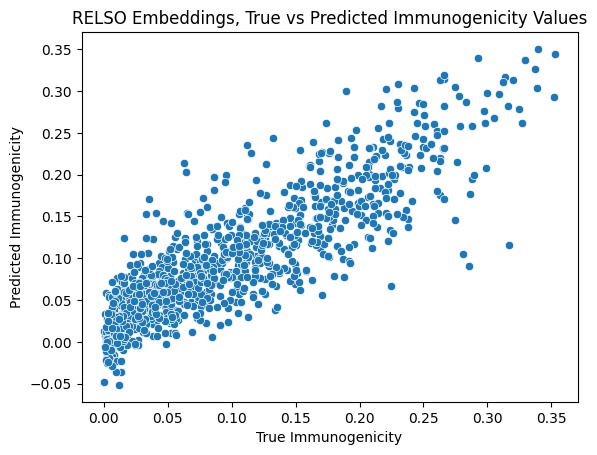

In [37]:
preds = torch.cat(predicted_values, dim =0).detach().numpy().tolist()
trues = test_immuno_df[1].tolist()
rdf = pd.DataFrame(trues)
rdf['preds'] = preds
rdf.columns = ['True Immunogenicity', 'Predicted Immunogenicity']
rdf

import seaborn as sns 
sns.scatterplot(data = rdf, x = 'True Immunogenicity', y = 'Predicted Immunogenicity').set_title('RELSO Embeddings, True vs Predicted Immunogenicity Values')


In [64]:
test_se.shape

torch.Size([1024, 30])

In [65]:
test_label.shape

torch.Size([1024, 1])

In [70]:
from torch.utils.data import TensorDataset, DataLoader
# Use se embedding
train_dataset = TensorDataset(train_se, train_label)
test_dataset = TensorDataset(test_se, test_label)

predicted_values = []

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.train()

epochs = 200

# Training loop
for epoch in range(epochs):
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # print(outputs.shape)
        # print(labels.shape)
        # print(torch.unique(labels))

        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    if epoch%10 == 0:
      print(f'Epoch {epoch}/{epochs} Loss: {loss.item()}')

model.eval()
test_loss = 0
# No need to track gradients for validation, we're not updating parameters
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        #print(outputs)
        predicted = outputs.squeeze()  # Sigmoid to bring output to [0, 1] range, and round off to get predictions
        predicted_values.append(predicted)
        # Update total and correct counts
        total += labels.size(0)
        test_loss += loss_fn(predicted,labels).sum().item()
    print(test_loss/total)
    print('Test loss: %f ' % (test_loss/total))

Epoch 0/200 Loss: 0.05460714176297188
Epoch 10/200 Loss: 0.007234977092593908
Epoch 20/200 Loss: 0.005278739146888256
Epoch 30/200 Loss: 0.006766249891370535
Epoch 40/200 Loss: 0.004487859085202217
Epoch 50/200 Loss: 0.005815180018544197
Epoch 60/200 Loss: 0.008143968880176544
Epoch 70/200 Loss: 0.006850854959338903
Epoch 80/200 Loss: 0.006105056498199701
Epoch 90/200 Loss: 0.007586194202303886
Epoch 100/200 Loss: 0.007074220571666956
Epoch 110/200 Loss: 0.0058554732240736485
Epoch 120/200 Loss: 0.0061304024420678616
Epoch 130/200 Loss: 0.006133394781500101
Epoch 140/200 Loss: 0.008059419691562653
Epoch 150/200 Loss: 0.007524386513978243
Epoch 160/200 Loss: 0.005405366886407137
Epoch 170/200 Loss: 0.007396170869469643
Epoch 180/200 Loss: 0.008601278066635132
Epoch 190/200 Loss: 0.00901982095092535
0.00010649853902577888
Test loss: 0.000106 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'SE(3)-Transformer Embeddings, True vs Pred Immunogenicity Values')

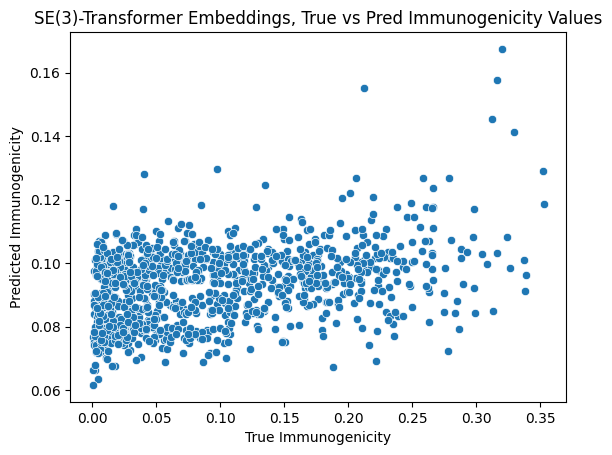

In [71]:
preds = torch.cat(predicted_values, dim =0).detach().numpy().tolist()
trues = test_immuno_df[1].tolist()
rdf = pd.DataFrame(trues)
rdf['preds'] = preds
rdf.columns = ['True Immunogenicity', 'Predicted Immunogenicity']
rdf

import seaborn as sns 
sns.scatterplot(data = rdf, x = 'True Immunogenicity', y = 'Predicted Immunogenicity').set_title('SE(3)-Transformer Embeddings, True vs Pred Immunogenicity Values')

In [72]:
class ImmunoModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=60, out_features= 120)
        self.layer2 = nn.Linear(in_features = 120, out_features = 30)
        self.layer3 = nn.Linear(in_features = 30, out_features = 15)
        self.layer4 = nn.Linear(in_features = 15, out_features = 6)
        self.layer5 = nn.Linear(in_features = 6, out_features = 1)
        # self.pretrained_model = model_0
        self.activation = torch.nn.ReLU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #z = self.pretrained_model(x)
        #return self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        a = self.activation(self.layer1(x))
        b = self.activation(self.layer2(a))
        c = self.activation(self.layer3(b))
        d = self.activation(self.layer4(c))
        return self.layer5(d)


model = ImmunoModelV1()


#BCELoss since we're doing classification 
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)


# Use all embedding
all_train_embed = torch.cat((train_embed,train_se),1)
all_test_embed = torch.cat((test_embed,test_se),1)
train_dataset = TensorDataset(all_train_embed, train_label)
test_dataset = TensorDataset(all_test_embed, test_label)

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

epochs = 200

predicted_values = []


# Training loop
for epoch in range(epochs):
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # print(outputs.shape)
        # print(labels.shape)
        # print(torch.unique(labels))

        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    if epoch%10 == 0:
      print(f'Epoch {epoch}/{epochs} Loss: {loss.item()}')

model.eval()
test_loss = 0
# No need to track gradients for validation, we're not updating parameters
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        predicted = outputs.squeeze()  # Sigmoid to bring output to [0, 1] range, and round off to get predictions
        predicted_values.append(predicted)
        # Update total and correct counts
        total += labels.size(0)
        test_loss += loss_fn(predicted,labels).sum().item()
    print(test_loss/total)
    print('Test loss: %f ' % (test_loss/total))

Epoch 0/200 Loss: 0.007942440919578075
Epoch 10/200 Loss: 0.0016831515822559595
Epoch 20/200 Loss: 0.0016311965882778168
Epoch 30/200 Loss: 0.001795616582967341
Epoch 40/200 Loss: 0.0013126691337674856
Epoch 50/200 Loss: 0.0008845704724080861
Epoch 60/200 Loss: 0.0009091441752389073
Epoch 70/200 Loss: 0.0011846794513985515
Epoch 80/200 Loss: 0.0013169581070542336
Epoch 90/200 Loss: 0.0012404442531988025
Epoch 100/200 Loss: 0.0011192109668627381
Epoch 110/200 Loss: 0.001112608122639358
Epoch 120/200 Loss: 0.0007833194686099887
Epoch 130/200 Loss: 0.0005669583333656192
Epoch 140/200 Loss: 0.0006616984028369188
Epoch 150/200 Loss: 0.0004499531933106482
Epoch 160/200 Loss: 0.00045076286187395453
Epoch 170/200 Loss: 0.000668883032631129
Epoch 180/200 Loss: 0.00042799109360203147
Epoch 190/200 Loss: 0.00043378237751312554
0.00019215388601878658
Test loss: 0.000192 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'SE(3)-Transformer + ReLSO, True vs Pred Immunogenicity Values')

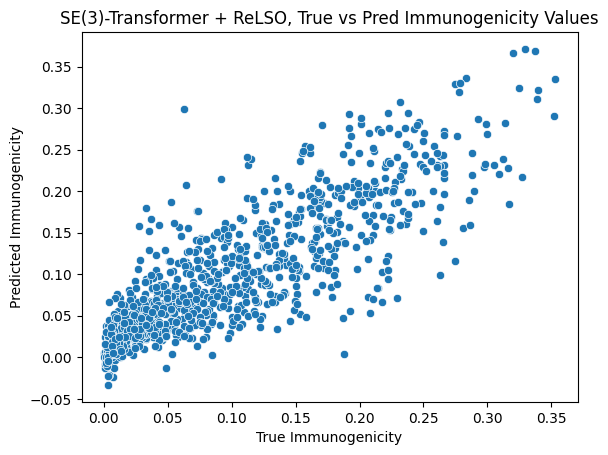

In [74]:
preds = torch.cat(predicted_values, dim =0).detach().numpy().tolist()
trues = test_immuno_df[1].tolist()
rdf = pd.DataFrame(trues)
rdf['preds'] = preds
rdf.columns = ['True Immunogenicity', 'Predicted Immunogenicity']
rdf

import seaborn as sns 
sns.scatterplot(data = rdf, x = 'True Immunogenicity', y = 'Predicted Immunogenicity').set_title('SE(3)-Transformer + ReLSO, True vs Pred Immunogenicity Values')

In [ ]:
print(train_embed.shape)
print(train_label.shape)
print(train_se.shape)

print(test_embed.shape)
print(test_label.shape)
print(test_se.shape)

In [ ]:
all_train_embed = torch.cat((train_embed,train_se),1)
print(all_train_embed.shape)

torch.Size([4094, 60])
